_Version log: Simulated Annealling._

In [30]:
import sys, time
import numpy as np
import CS_functions as cs
from tqdm import tqdm
from matplotlib import pyplot as plt, lines as mpllines, patches as patches
from scipy.constants import c as C

plt.rcParams.update({'font.size':24, 'lines.markersize': 6.0, 'lines.linewidth': 2.0, 'figure.facecolor': 'none', 'axes.facecolor': 'white'})
np.set_printoptions(threshold=sys.maxsize)

In [2]:
file_number = 31
file_name = "1dmockanderrors{:d}".format(file_number)
file_type = ".csv"

target, target_err = cs.open_dataset(file_name, ".csv")
optlocs_file = "data\\" + file_name +"_optlocs.csv"

training_file_number = 32
training_file_name = "1dmockanderrors{:d}".format(training_file_number)
training, training_err = cs.open_dataset(training_file_name, ".csv")


In [3]:
reduced_points = 4
max_temp = 51
regularization_coeffient = 1e-2 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e0)
min_seperation= 1
iterations= 5000
cooling= 0.995
subsampling_method= "random"

In [4]:
#########INITAILISATION##########

start_time = time.time()

temps = []
scores = np.array([])
total_points = target.shape[-1]
detectors = cs.subsample_1d(total_points, reduced_points, subsampling_method)
initialisation_detectors = np.copy(detectors)
score = new_score = cs.evaluate_score(detectors, target, target_err, training, regularization_coeffient= regularization_coeffient, error_type= "L2")
target_temp = max_temp
improvement = True

#######START SIMULATED ANNEALLING###########
for n in tqdm(range(iterations)):
    t = round(target_temp) #reset steps
    new_detectors = np.copy(detectors) #reset detectors
    new_score = np.copy(score) #reset score

    while t > 0:
        random_detector = np.random.randint(0, reduced_points) #random number between 0 and reduced_points. Includes 0. Excludes reduced_points
        current = new_detectors[random_detector]
        previous = -1 if random_detector == 0 else new_detectors[random_detector -1] #consider making the end points fixed. It helps define the length of the detector array.
        next = total_points if random_detector == reduced_points -1 else new_detectors[random_detector +1]
        if previous +min_seperation < current and current < next -min_seperation:
            #detector has space to move forward or back.
            new_detectors[random_detector] += np.random.choice([-1,1])
            t -= 1
        elif previous +min_seperation < current:
            #detector has space to move back.
            new_detectors[random_detector] -= 1
            t -= 1
        elif current < next -min_seperation:
            #detector has space to move forward.
            new_detectors[random_detector] += 1
            t -= 1
        else:
            #detector can't move.
            pass

    temps = temps + [[target_temp, np.linalg.norm(new_detectors -detectors, ord= 1)]] #L1 norm represents the number of times that the detectors were moved
    new_score = cs.evaluate_score(new_detectors, target, target_err, training, regularization_coeffient, error_type= "L2")

    if new_score < score:
        detectors = new_detectors
        score = new_score
        improvement = True
        best_iteration = n

    if target_temp <= 1: #When cold, stop optimising and start exploring new possiblities.
        target_temp = max_temp
        improvement = False
    elif improvement: #When hot, stop exploring and start optimising this regime.
        target_temp *= cooling

    scores = np.append(scores, score)

temps = np.array(temps).T

runtime = time.time() -start_time
print(f"Sim Annealing searched for {runtime} seconds and found a solution after {runtime *best_iteration/iterations} seconds")

100%|██████████| 5000/5000 [00:05<00:00, 833.76it/s] 

Sim Annealing searched for 6.022090196609497 seconds and found a solution after 2.5654104237556457 seconds


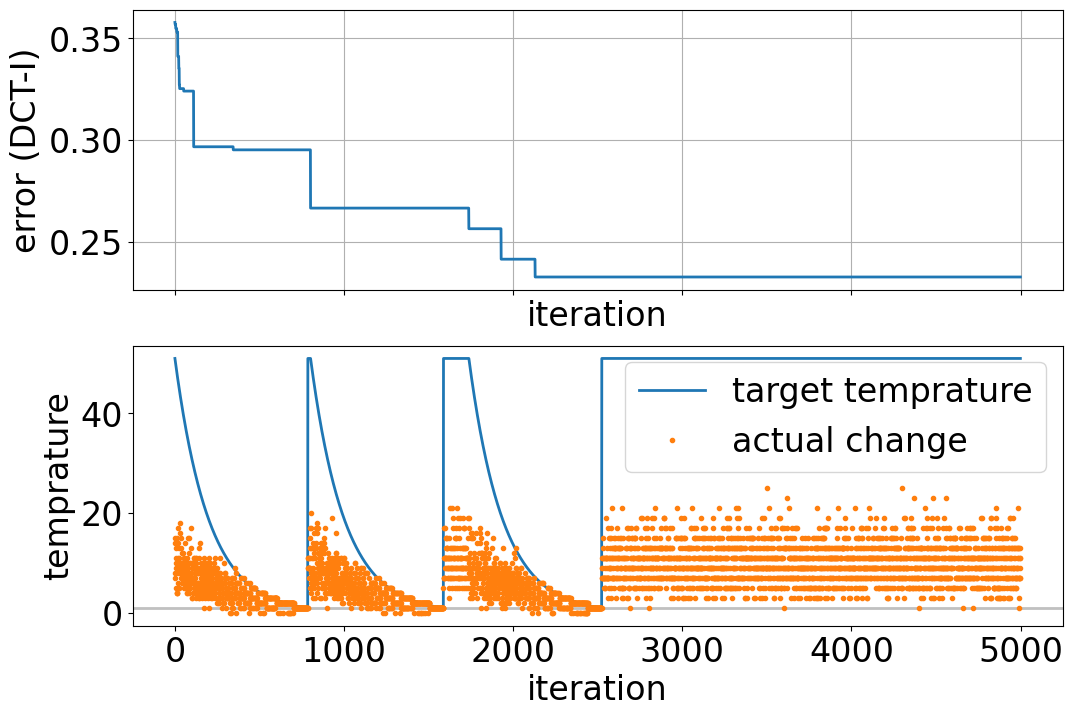

best score = 0.233


In [5]:
fig, axs = plt.subplots(2,1, sharex= True, figsize= (12,8))

axs[0].plot(scores)
axs[0].grid(True)
axs[0].set(ylabel= "error (DCT-I)", xlabel= "iteration")

axs[1].hlines(1, 0, 1, color= "silver", transform=axs[1].get_yaxis_transform())
axs[1].plot(temps[0], label= "target temprature") #target temprature
axs[1].plot(temps[1], marker= ".", linestyle= "None", label= "actual change") #actual temprature due to bounds constraints.
axs[1].set(ylabel= "temprature", xlabel= "iteration")
axs[1].legend()

plt.show()

print("best score = {:.3f}".format(score))

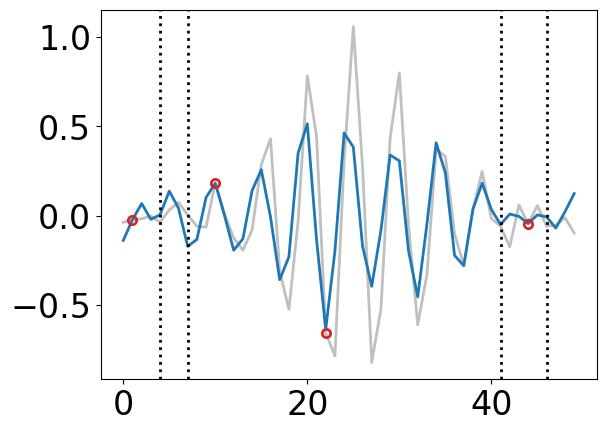

In [6]:
samples = np.full_like(target, np.nan)
samples[detectors] = target[detectors]
result = cs.compressed_sensing(samples, regularization_coeffient)

plt.plot(target, color= "silver")
plt.plot(result)
plt.plot(samples, marker= "o", linestyle= "none", markeredgecolor= "tab:red", markerfacecolor= "none", markeredgewidth= 2)
plt.vlines(initialisation_detectors, ymin= 0, ymax= 1, linestyle= ":", color= "k", transform= plt.gca().get_xaxis_transform())
plt.show()

In [7]:
cs.append_array_to_csv(detectors, optlocs_file)

print(*detectors, sep= ",")

1,10,22,44


## PROBIBLITY DISTROBUTION FOR WHERE THE SENSORS END UP AFTER SA OPTIMISATION

In [8]:
optlocs_file = r"data/1dmockanderrors32_randoptlocs.csv"
file_name = "1dmockanderrors32"
theta = 360 # arcminutes
pixel_pitch = 1.0

sensor_distrobution = cs.open_csv(optlocs_file, number_of_columns= 8)
#sensor_distrobution = sensor_distrobution[1000:]
target, uncertainties = cs.open_dataset(file_name, file_type)
total_point = len(target)
displacement = np.arange(-total_point//2, total_point//2) *pixel_pitch # 50 points, pixel pitch = 1.0 mm

In [9]:
frequent_locs = np.array(np.unique(sensor_distrobution, return_counts=True)).T
sensor_distrobution = np.ravel(sensor_distrobution[~np.isnan(sensor_distrobution)])
sensor_distrobution = sensor_distrobution *pixel_pitch -total_point//2 #mm
#frequent_locs = frequent_locs[:-1] #remove nans
frequent_locs = frequent_locs[frequent_locs[:, 1].argsort()[::-1]]
#frequent_locs = [frequent_locs[frequent_locs[:,0].tolist().index(n),1] if n in frequent_locs[:,0] else np.nan for n in range(total_point)] # Put it back in order of sensor index.
#frequent_locs = np.array(frequent_locs)
print("Detector locations: Occurrences")
print(frequent_locs[:, :])

Detector locations: Occurrences
[[ 25 793]
 [ 23 777]
 [ 13 241]
 [ 11 239]
 [ 47 222]
 [ 33 218]
 [ 45 209]
 [ 39 203]
 [ 30 203]
 [  5 200]
 [ 41 199]
 [ 20 189]
 [  7 188]
 [  3 188]
 [ 22 186]
 [ 43 186]
 [ 15 184]
 [  1 166]
 [  8 159]
 [ 28 153]
 [ 44 143]
 [ 37 141]
 [ 42 138]
 [ 35 136]
 [  9 130]
 [ 17 126]
 [ 21 122]
 [  2 116]
 [ 27 113]
 [  6 110]
 [ 26 109]
 [ 18 108]
 [ 29 106]
 [ 19 106]
 [ 48 105]
 [  4  95]
 [ 36  89]
 [ 31  88]
 [ 49  86]
 [ 32  85]
 [ 46  84]
 [ 40  84]
 [ 10  80]
 [ 38  73]
 [  0  70]
 [ 34  69]
 [ 14  53]
 [ 12  51]
 [ 16  49]
 [ 24  32]]


In [10]:
frequent_locs = [frequent_locs[frequent_locs[:,0].tolist().index(n),1] if n in frequent_locs[:,0] else 0 for n in range(total_point)] # Put it back in order of sensor index.
frequent_locs = np.array(frequent_locs)

In [11]:
total_point

50

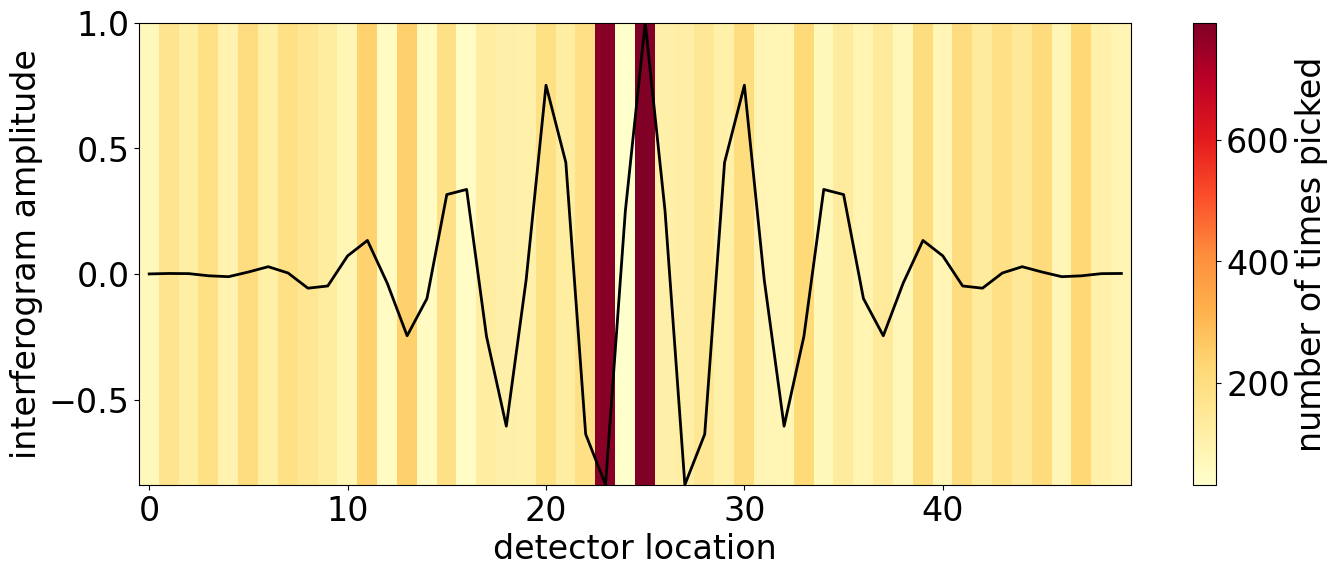

In [12]:
fig, axs = plt.subplots(figsize= (16,6))

axs.plot(target, color= "k", linewidth= 2, label= "interferogram")

im = plt.imshow([frequent_locs], aspect= "auto", extent= (-0.5, total_point -0.5, min(target), max(target)), cmap= "YlOrRd")#, norm= "log")
plt.colorbar(im, label= "number of times picked")

axs.set(xlabel= "detector location", ylabel= "interferogram amplitude")
plt.show()

In [13]:
print(sensor_distrobution.min(), sensor_distrobution.max())

-25.0 24.0


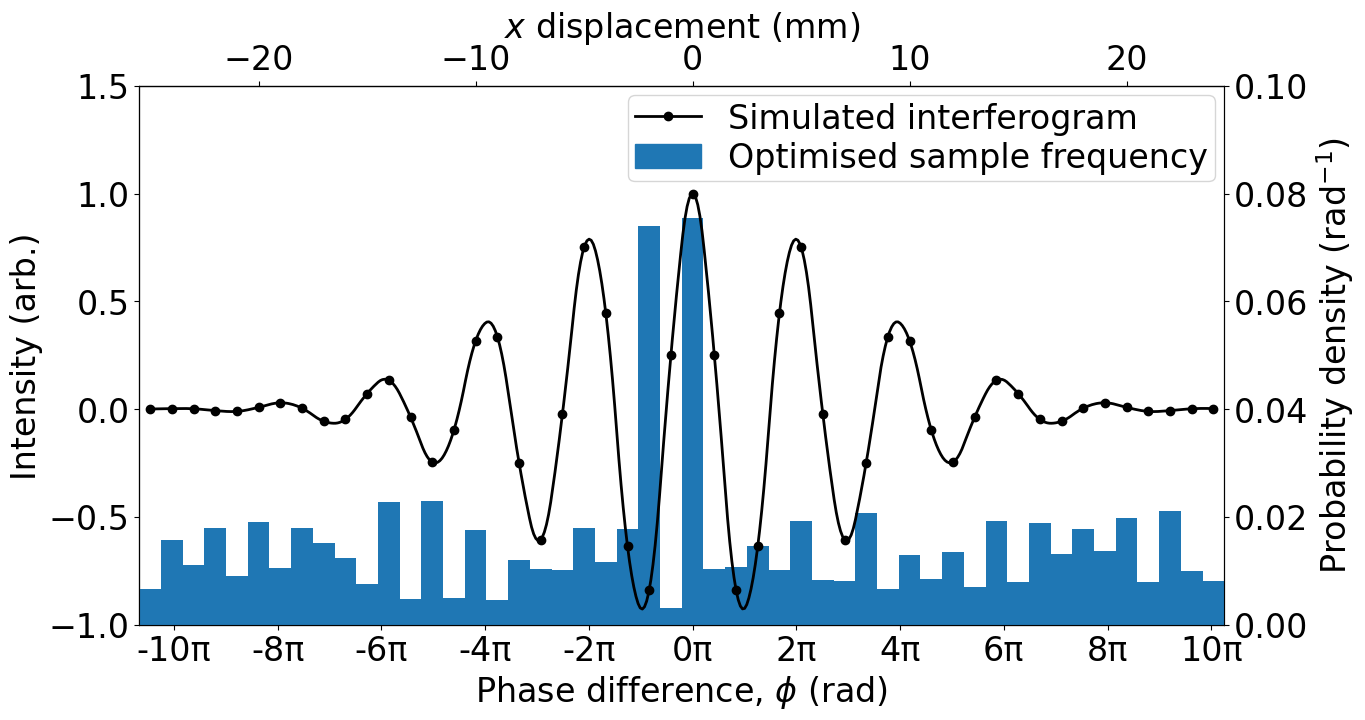

In [48]:
bins = int(total_point//1)

def displacement2phase(displacement):
    return displacement*1e-3 * 2*np.sin(np.deg2rad(theta/60)) * 300e9/C * 2*np.pi
def phase2displacement(phase):
    return phase/(2*np.pi) / (2*np.sin(np.deg2rad(theta/60))) * C/300e9 * 1e3

phase_difference = displacement2phase(displacement)
sensor_phase = displacement2phase(sensor_distrobution)

### Create figure and axes (including secondary and twin axes)
fig, axs = plt.subplots(figsize= (14,7))
secax = axs.secondary_xaxis('top', functions=(phase2displacement, displacement2phase))
twinax = axs.twinx()
invisibleax = axs.twinx()

### Plot histogram on primary axes
dtheta = phase_difference[1] -phase_difference[0]
hist = axs.hist(sensor_phase, bins= bins,
         range= (phase_difference[0] -dtheta/2, phase_difference[-1] +dtheta/2),
         density= True, zorder= 3, label= "a")
axs.set(ylabel= "Probability density (rad$^{-1}$)",
        xlabel= r"Phase difference, $\phi$ (rad)",
        xlim= (phase_difference[0] -dtheta/2, phase_difference[-1] +dtheta/2),
        ylim= (0, 0.1),
        xticks= np.arange(-10*np.pi, 10*np.pi +np.pi, 2*np.pi),
        xticklabels= [f"{i/np.pi:.0f}π" for i in np.arange(-10*np.pi, 10*np.pi +np.pi, 2*np.pi)])
axs.yaxis.set_label_position("right"); axs.yaxis.tick_right()
# axs.grid(visible= True, axis= "x")
axs.patch.set_visible(False)

### Put displacement on secondary x-axis
secax.set_xlabel("$x$ displacement (mm)")

### Plot interferogram on twin y-axis
twinax.plot(phase_difference, target, color= "k", linewidth= 2, linestyle= "none", marker= "o")
twinax.plot(cs.interpolate(phase_difference), cs.interpolate(target), color= "k", label= "simulated interferogram")
twinax.set(ylabel= "Intensity (arb.)", ylim= (-1.0, 1.5))
twinax.yaxis.set_label_position("left"); twinax.yaxis.tick_left()

### Plot invisible twin y-axis to make the grid appear behind the histogram
invisibleax.set_zorder(-1)
invisibleax.set_ylim(twinax.get_ylim())
invisibleax.set_xticks(ticks= np.arange(-10*np.pi, 10*np.pi +np.pi, 2*np.pi))
invisibleax.tick_params(right=False, labelright=False, bottom= False, labelbottom=False)
invisibleax.spines['right'].set_visible(False)
invisibleax.patch.set_visible(True)
# invisibleax.grid(True)


legend_elements = [mpllines.Line2D([0], [0], color= "black", marker= "o", label= "Simulated interferogram"),
                   patches.Rectangle([0,0], 1, 1, color= "tab:blue", label= "Optimised sample frequency")]

fig.legend(handles=legend_elements, loc= "upper right", bbox_to_anchor= (0.905, 0.89), labelspacing= 0.2, borderpad= 0.2)
fig.savefig("./graphs/mockanderrors32_histogram_L2error.png", bbox_inches= "tight")
plt.show()

In [28]:
print(type(hist[-1][0]))

<class 'matplotlib.patches.Rectangle'>
